I want to create a model that predicts the liklyhood a batted ball in play will be a hit or not. I will use the launch angle and exit velocity as features in my model. 

I will be collecting my data using pybaseball to reteive stats from basebal savant.

In [30]:
import pybaseball as pybb
import pandas as pd
import numpy as np

data = pd.DataFrame(pybb.statcast(start_dt='2022-05-01', end_dt='2022-05-15'))
data.head(2)

#looking at the data we want to filter to only have data on balls batted in play.
#we will only need events, description, launch_speed, and launch_angle

This is a large query, it may take a moment to complete


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3124,FF,2022-05-15,94.3,-1.65,5.88,"Wick, Rowan",444482,592858,grounded_into_double_play,hit_into_play,...,3,3,2,2,3,Standard,Standard,198,-0.326,-0.832
3201,FF,2022-05-15,93.1,-1.73,5.91,"Wick, Rowan",444482,592858,NaN,called_strike,...,3,3,2,2,3,Standard,Standard,197,0.0,-0.092


In [31]:
#select the desired columns
data = data[["description","events","launch_speed", "launch_angle"]]
#filter to only have ball hit into play
data = data[data["description"] == "hit_into_play"]



#I want to create a new column for hit or not, 1 being a hit, and 0 being any other outcome(out, error.....)
data['hit'] = [1 if x == 'single' or x == 'double' or x == 'triple' or x == 'home_run' else 0 for x in data['events']]

#Also adding hittype to show hit outcome
condition = [
    (data['events'] == "single"),
    (data['events'] == "double"),
    (data['events'] == "triple"),
    (data['events'] == "home_run")
]

choices = [1,2,3,4]

data['hitType'] = np.select(condition, choices, default=0)

data.head(10)




,description,events,launch_speed,launch_angle,hit,hitType
3124,hit_into_play,grounded_into_double_play,107.0,1,0,0
3700,hit_into_play,field_out,81.5,81,0,0
4070,hit_into_play,single,70.8,31,1,1
3042,hit_into_play,single,96.6,13,1,1
4037,hit_into_play,field_out,99.8,-10,0,0
2987,hit_into_play,field_out,97.5,2,0,0
3228,hit_into_play,single,63.4,19,1,1
3856,hit_into_play,double,110.2,19,1,2
3070,hit_into_play,field_out,97.1,24,0,0
3418,hit_into_play,field_out,85.8,40,0,0


Now I will plot the data to see if we can spot any patterns related to launch angle, and speed. 

In [32]:
#(data['launch_angle'].values == '').sum()
#found some empty values and need to get ride of them
data[data['launch_angle'].isna()]
data = data.dropna()




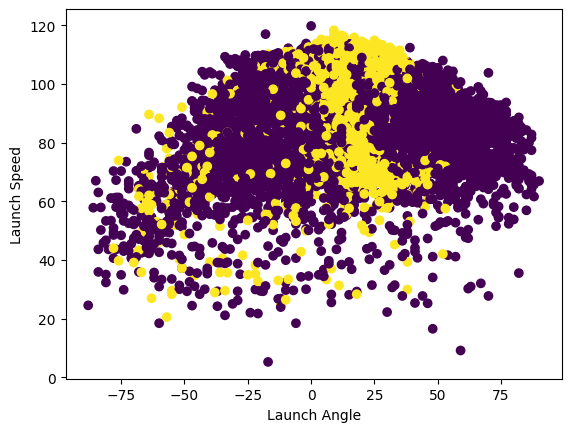

In [33]:
import matplotlib.pyplot as plt

plt.scatter(data["launch_angle"], data["launch_speed"],c=data.hit)
plt.xlabel("Launch Angle")
plt.ylabel("Launch Speed")
plt.show()

Now lets start to train a model. 
I will use Logistic Regression

In [34]:
import tensorflow as tf

In [35]:
#split data into training and testing data
X = pd.DataFrame(data[['launch_angle', 'launch_speed']])
X = np.asarray(X).astype('float32')
y = pd.DataFrame(data['hit'])
split = int(len(X) * 0.8)
train_X = X[:split]
train_y = y[:split]
test_X = X[split:]
test_y = y[split:]

In [41]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(4, activation='relu', input_shape=(2,)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=100, verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_X, test_y, verbose=0)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.7518391609191895
